**Chaira Harder**

**MTH 354 Mathematics of Deep Learning**

**Professor Luca Capogna**

#**NUTRIEST: Nutritional Estimation Using a Convolutional Neural Network (CNN)**

##Data

The data used to train this model, called **Nutriest**, comes from the '[Recipe Images with Nutritional Information](https://www.kaggle.com/datasets/crispen5gar/recipe-images-with-nutritional-information?resource=download)' dataset from Kaggle. It contains 2,167 images of various recipes, each paired with detailed nutritional information including calories, protein, carbohydrates (carbs), sugars, salts,saturates, and fats. I will only be focusing on my calorie count and macros, so: kcal, proteins, carbs, and fats for the output.

Considering the number of images used to train this model is relatively low, and a few images will likely be wrangled and removed from the training dataset, I will focus on optimizing generability for this model.

The goal with this project is to train a Convolutional Neural Network (CNN) to predict nutritional content from food images, to potentially serve as a quicker and efficient way to track meal content and support my healthy eating journey.

**Nutriest** demonstrates the potential of deep learning in health and dietary planning.

Mounted at /content/drive
   index                                          image  carbs   fat  fibre  \
0      1    recipe-image-legacy-id-46013_11-99b8eda.jpg   30.0  11.0    2.0   
1      2   recipe-image-legacy-id-743466_11-e87df17.jpg   38.0   7.0    2.0   
2      3  recipe-image-legacy-id-1119465_11-4aebb21.jpg   22.0  17.0    1.0   
3      4  recipe-image-legacy-id-1201816_10-7f0a38f.jpg   32.0   9.0    2.0   
4      9  recipe-image-legacy-id-1025484_11-f56ab42.jpg   25.0  11.0    1.0   

    kcal  protein  salt  saturates  sugars  
0  275.0     17.0  1.99        6.0     4.0  
1  240.0      8.0  1.37        2.0     1.0  
2  294.0     13.0  1.50        9.0     1.0  
3  250.0     12.0  1.00        5.0     3.0  
4  218.0      6.0  0.60        6.0     1.0  


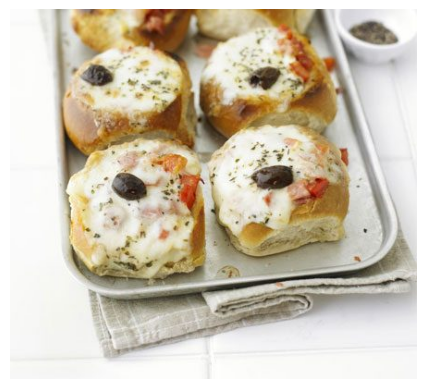

In [ ]:
# IMPORTING LIBRARIES
# ---------------------

import kagglehub
import numpy as np
import sympy as sp
import pandas as pd
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras import layers, models
import os
import cv2 # openCV for computer vision

from google.colab import drive
from google.colab import files
drive.mount('/content/drive')

base_path = '/content/drive/My Drive/nutriest/' # the google drive folder I have this file + the data + images stored
csv_path = base_path + 'data.csv' # nutritional data for each corresponding image


# PROCESSING THE NUTRITIONAL INFORMATION (data.csv)
# ---------------------

# ignore this
# path = kagglehub.dataset_download("crispen5gar/recipe-images-with-nutritional-information")
data = pd.read_csv(csv_path)
print(data.head())


# PROCESSING THE IMAGES
# ---------------------

# Path to the images folder
images_path = base_path + 'images'

# loading one image to test:
# test_load_image = data['Zingy-grapefruit-prawn-avocado-and-tamarind-salad-070c1d9'][0]
test_load_image = data['image'][0]
image_path = os.path.join(images_path, test_load_image)

img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # convert to rgb for matplotlib

# display image
plt.imshow(img)
plt.axis('off')
plt.show()


In [ ]:
# DATA WRANGLING: LOADING THE IMAGES AND FILTERING -- THIS CAN TAKE A FEW MINUTES
# ---------------------

'''
this function returns a tupple for loaded images, missing images, and corresponding valid indices.
'''
def load_images(data, images_path, image_size=(224, 224)):
  images = []
  missing_images = []
  valid_indices = []

  for i, img_name in enumerate(data['image']):
      img_path = os.path.join(images_path, img_name)
      img = cv2.imread(img_path)
      if img is not None:
          img = cv2.resize(img, image_size)
          images.append(img)
          valid_indices.append(i)  # Keep track of valid row indices
      else:
          print(f"IMG not found: {img_path}")
          missing_images.append(img_name)

  return images, missing_images, valid_indices



# COMBINING NUTRITIONAL AND IMAGE DATA
# ---------------------

images, missing_images, valid_indices = load_images(data, images_path)


print(f"Loaded {len(images)} images.")
print(f"MISSING {len(missing_images)} IMAGES: {missing_images}")

# removing missing images data from data.csv nutritional info
data_filtered = data.iloc[valid_indices]
print(f"Filtered data contains {len(data_filtered)} rows.")


x_im = np.array(images)
# y_labs = data[['kcal', 'protein', 'carbs', 'fat']].values  # output
y_labs = data_filtered[['kcal', 'protein', 'carbs', 'fat']].values

print(f"x_im shape: {x_im.shape}, y_labs shape: {y_labs.shape}")

x_im = x_im / 255.0  # normalize to range [0, 1] -- tutorials are doing this


IMG not found: /content/drive/My Drive/nutriest/images/roasted-summer-veg-casserole-3c459e9.png
IMG not found: /content/drive/My Drive/nutriest/images/Jerk-Style-Cauliflower-With-Coconut-Rice-2c54f98.jpg
IMG not found: /content/drive/My Drive/nutriest/images/Giant-Couscous-Salad-With-Charred-Veg-Tangy-Pesto-aea3737.jpg
IMG not found: /content/drive/My Drive/nutriest/images/Giant-Couscous-Salad-With-Charred-Veg-Tangy-Pesto-aea3737.jpg
IMG not found: /content/drive/My Drive/nutriest/images/KimchiPancakes-e591d25.jpg
IMG not found: /content/drive/My Drive/nutriest/images/TteokbokkiSpicyRiceCakes-b78e346.jpg
IMG not found: /content/drive/My Drive/nutriest/images/Vegan-carbonara-ebf05ee.jpg
IMG not found: /content/drive/My Drive/nutriest/images/Giant-Couscous-Salad-With-Charred-Veg-Tangy-Pesto-aea3737.jpg
IMG not found: /content/drive/My Drive/nutriest/images/Vegan-carbonara-ebf05ee.jpg
Loaded 1249 images.
MISSING 9 IMAGES: ['roasted-summer-veg-casserole-3c459e9.png', 'Jerk-Style-Cauliflowe

##Process

#### Splitting the dataset into Testing and Training sets

In [ ]:
# SPLITTING DATASET
# ---------------------

X_train, X_test, y_train, y_test = train_test_split(x_im, y_labs, test_size=0.2, random_state=42)

print(f"training shape: {X_train.shape}, {y_train.shape}")
print(f"testing shape: {X_test.shape}, {y_test.shape}")

training shape: (999, 224, 224, 3), (999, 4)
testing shape: (250, 224, 224, 3), (250, 4)


#### MVP: A Basic CNN

In [ ]:
# BUILDING THE BASIC MODEL MVP
# ---------------------

basic_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(4, activation='linear')
])

basic_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
basic_model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 186624)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      23,888,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,907,908 (91.20 MB)

 Trainable params: 23,907,908 (91.20 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# TRAINING THE BASIC MODEL -- this step takes a few minutes.
# ---------------------

history = basic_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=10,
    batch_size=32,
    verbose=1
)

Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 97s 3s/step - loss: 17008.5645 - mae: 72.7677 - val_loss: 7267.9834 - val_mae: 42.6918
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 148s 3s/step - loss: 9817.6758 - mae: 57.9370 - val_loss: 7056.3301 - val_mae: 41.2919
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 140s 3s/step - loss: 7155.5718 - mae: 49.5428 - val_loss: 6727.2788 - val_mae: 38.7254
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 137s 3s/step - loss: 6882.8955 - mae: 47.2766 - val_loss: 6662.5220 - val_mae: 38.1129
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 141s 3s/step - loss: 6375.1743 - mae: 43.6097 - val_loss: 6194.6743 - val_mae: 37.2951
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 142s 3s/step - loss: 5652.1475 - mae: 42.5526 - val_loss: 6285.6440 - val_mae: 38.1420
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 142s 3s/step - loss: 5369.0664 - mae: 40.6519 - val_loss: 5877.8779 - val_mae: 35.2990
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 148s 3s/step - loss: 4684.0474 - mae: 36.6741 - val_loss: 6464.9653 - val_mae: 37.8565


8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 978ms/step - loss: 6442.5654 - mae: 34.3826
Loss: 5650.7548828125
Mean Absolute Error (MAE): 32.62554931640625


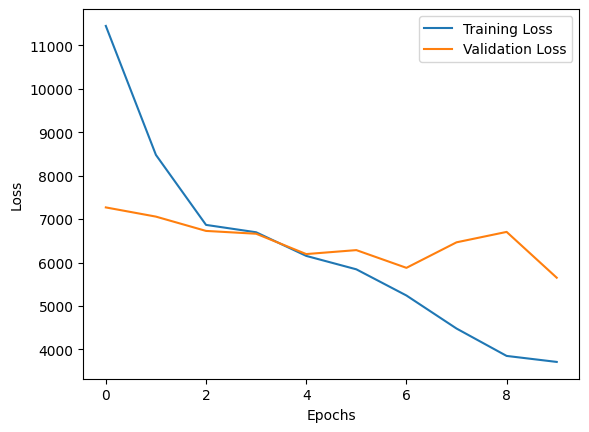

In [ ]:
loss, mae = basic_model.evaluate(X_test, y_test, verbose=1)
print(f"Loss: {loss}")
print(f"Mean Absolute Error (MAE): {mae}")

# PLOTTING LOSS:
# ---------------------

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# TEST ONE PREDICTION/IMAGE
# ---------------------

sample_image = X_test[0]
sample_label = y_test[0]

# PREDICT
# ---------------------

predicted_label = basic_model.predict(sample_image[np.newaxis, ...])

print(f"True Label: {sample_label}")
print(f"Predicted Label: {predicted_label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step
True Label: [197.   9.  15.  11.]
Predicted Label: [[187.72221     3.4164011  22.206823    7.996737 ]]


#### A Better Model: Nutriest

In [ ]:
# BUILDING LAYERED MODEL
# ---------------------

nutriest_model = models.Sequential([
    layers.AveragePooling2D(pool_size=(6, 6), strides=3, input_shape=(300, 300, 3)),

    # three convolutional blocks:
    layers.Conv2D(64, kernel_size=3, activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    # layers.Dropout(0.3), # check -- is this best to prevent overfitting

    layers.Conv2D(128, kernel_size=3, activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    # layers.Dropout(0.4),

    layers.Conv2D(256, kernel_size=3, activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    # layers.Dropout(0.5),

    layers.GlobalAveragePooling2D(),

    # flatten layers
    # layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(4, activation='linear')
])



nutriest_model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mae'])

nutriest_model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/pooling/base_pooling.py:23: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(name=name, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ average_pooling2d (AveragePooling2D) │ (None, 99, 99, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 97, 97, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 48, 48, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 46, 46, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 23, 23, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 21, 21, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 10, 10, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 256)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 404,228 (1.54 MB)

 Trainable params: 404,228 (1.54 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# TRAINING LAYERED MODEL -- this takes a few minutes
# ---------------------

history = nutriest_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=32,
    verbose=1
)

Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - loss: 30784.7969 - mae: 96.2417 - val_loss: 7116.7773 - val_mae: 43.2624
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - loss: 9550.3945 - mae: 61.8622 - val_loss: 6772.9053 - val_mae: 40.4235
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - loss: 8108.6792 - mae: 55.5578 - val_loss: 6558.2637 - val_mae: 39.0567
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - loss: 8530.0176 - mae: 54.6082 - val_loss: 6519.8584 - val_mae: 39.0887
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - loss: 8148.3525 - mae: 52.1563 - val_loss: 6514.8257 - val_mae: 39.3694
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - loss: 7832.4087 - mae: 50.0395 - val_loss: 6557.7114 - val_mae: 39.2310
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - loss: 7905.6748 - mae: 49.3743 - val_loss: 6566.2739 - val_mae: 39.2318
Epoch 8/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - loss: 7503.4224 - mae: 47.5575 - val_loss: 8208.8857 - val_mae: 45.9414
Epoch 9

A recurring issue I had here -- the shape of the model's output didn't match the target labels y_train and y_test, so I couldn't fit the model until I flattened the vector.

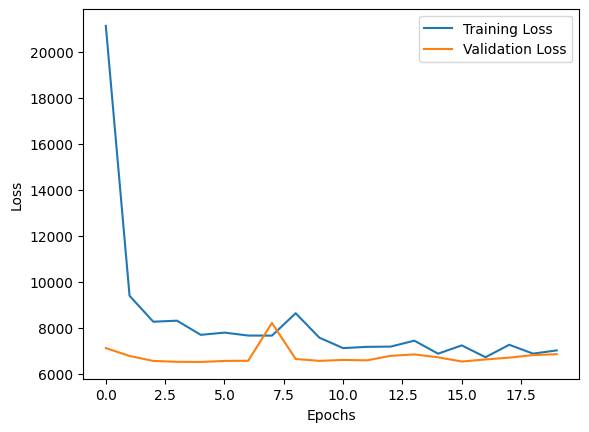

In [ ]:
# VISUALIZE LAYERED MODEL LOSS
# ---------------------

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# EVALUATING THE LAYERED MODEL
# ---------------------

loss, mae = nutriest_model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {loss}")
print(f"Mean Absolute Error (MAE): {mae}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 393ms/step - loss: 7237.0073 - mae: 41.8321
Test Loss: 6719.2177734375
Mean Absolute Error (MAE): 39.99748611450195


The loss function here compared to the basic model looks better.

#### Testing and Comparing the Models

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
True: [197.   9.  15.  11.]
Predicted: [[374.0013    19.404934  39.10752   14.619404]]
Loaded 2 images for testing.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
Predicted Nutritional Values for 'mypizza.jpg':
Calories: 387.0
Protein: 20.1
Carbs: 40.5
Fat: 15.1
------------------------------
Predicted Nutritional Values for 'mypeaches.jpg':
Calories: 364.4
Protein: 18.9
Carbs: 38.1
Fat: 14.2
------------------------------


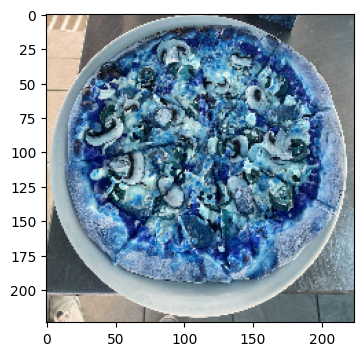

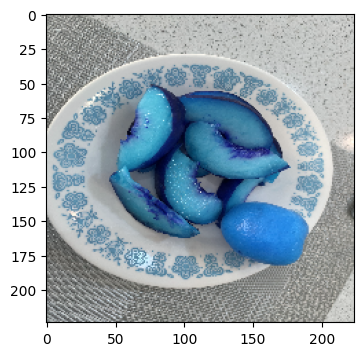

In [ ]:
# COMPARING THE MODELS WITH A RANDOM TEST
# ---------------------

sample_image = X_test[0]
sample_label = y_test[0]


# PREDICT ON AN IMAGE FROM TEST
# ---------------------

predicted_label = nutriest_model.predict(sample_image[np.newaxis, ...])

print(f"True: {sample_label}")
print(f"Predicted: {predicted_label}")


# USING A PERSONAL MEAL PICTURE
# ---------------------

mytests_path = '/content/drive/My Drive/nutriest/mytests/'
mytest_images = os.listdir(mytests_path)

personal_test_data = pd.DataFrame({'image': mytest_images})
# print(personal_test_data)

personal_images, missing_images, valid_indices = load_images(personal_test_data, mytests_path, image_size=(224, 224))

personal_images = np.array(personal_images) / 255.0

print(f"Loaded {len(personal_images)} images for testing.")


# PERSONAL MEAN PREDICTION

personal_predictions = nutriest_model.predict(personal_images)

for i, img_name in enumerate(personal_test_data['image']):
  plt.figure(figsize=(4, 4))
  plt.imshow(personal_images[i])
  print(f"Predicted Nutritional Values for '{img_name}':")
  print(f"Calories: {personal_predictions[i][0]:.1f}")
  print(f"Protein: {personal_predictions[i][1]:.1f}")
  print(f"Carbs: {personal_predictions[i][2]:.1f}")
  print(f"Fat: {personal_predictions[i][3]:.1f}")
  print("-" * 30)


##Appendix

In [ ]:
### CODE APPENDIX
# ---------------------
# ---------------------


# IMPORTING LIBRARIES
# ---------------------

import kagglehub
import numpy as np
import sympy as sp
import pandas as pd
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras import layers, models
import os
import cv2 # openCV for computer vision

from google.colab import drive
from google.colab import files
drive.mount('/content/drive')

base_path = '/content/drive/My Drive/nutriest/' # the google drive folder I have this file + the data + images stored
csv_path = base_path + 'data.csv' # nutritional data for each corresponding image


# PROCESSING THE NUTRITIONAL INFORMATION (data.csv)
# ---------------------

# ignore this
# path = kagglehub.dataset_download("crispen5gar/recipe-images-with-nutritional-information")
data = pd.read_csv(csv_path)
print(data.head())


# PROCESSING THE IMAGES
# ---------------------

# Path to the images folder
images_path = base_path + 'images'

# loading one image to test:
# test_load_image = data['Zingy-grapefruit-prawn-avocado-and-tamarind-salad-070c1d9'][0]
test_load_image = data['image'][0]
image_path = os.path.join(images_path, test_load_image)

img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # convert to rgb for matplotlib

# display image
plt.imshow(img)
plt.axis('off')
plt.show()

# DATA WRANGLING: LOADING THE IMAGES AND FILTERING -- THIS CAN TAKE A FEW MINUTES
# ---------------------

'''
this function returns a tupple for loaded images, missing images, and corresponding valid indices.
'''
def load_images(data, images_path, image_size=(224, 224)):
  images = []
  missing_images = []
  valid_indices = []

  for i, img_name in enumerate(data['image']):
      img_path = os.path.join(images_path, img_name)
      img = cv2.imread(img_path)
      if img is not None:
          img = cv2.resize(img, image_size)
          images.append(img)
          valid_indices.append(i)  # Keep track of valid row indices
      else:
          print(f"IMG not found: {img_path}")
          missing_images.append(img_name)

  return images, missing_images, valid_indices



# COMBINING NUTRITIONAL AND IMAGE DATA
# ---------------------

images, missing_images, valid_indices = load_images(data, images_path)


print(f"Loaded {len(images)} images.")
print(f"MISSING {len(missing_images)} IMAGES: {missing_images}")

# removing missing images data from data.csv nutritional info
data_filtered = data.iloc[valid_indices]
print(f"Filtered data contains {len(data_filtered)} rows.")


x_im = np.array(images)
# y_labs = data[['kcal', 'protein', 'carbs', 'fat']].values  # output
y_labs = data_filtered[['kcal', 'protein', 'carbs', 'fat']].values

print(f"x_im shape: {x_im.shape}, y_labs shape: {y_labs.shape}")

x_im = x_im / 255.0  # normalize to range 0-1


# SPLITTING DATASET
# ---------------------

X_train, X_test, y_train, y_test = train_test_split(x_im, y_labs, test_size=0.2, random_state=42)

print(f"training shape: {X_train.shape}, {y_train.shape}")
print(f"testing shape: {X_test.shape}, {y_test.shape}")


# BUILDING THE BASIC MODEL MVP
# ---------------------

basic_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(4, activation='linear')
])

basic_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
basic_model.summary()


# TRAINING THE BASIC MODEL -- this step takes a few minutes.
# ---------------------

history = basic_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=10,
    batch_size=32,
    verbose=1
)


loss, mae = basic_model.evaluate(X_test, y_test, verbose=1)
print(f"Loss: {loss}")
print(f"Mean Absolute Error (MAE): {mae}")

# PLOTTING LOSS:
# ---------------------

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


# TEST ONE PREDICTION/IMAGE
# ---------------------

sample_image = X_test[0]
sample_label = y_test[0]

# PREDICT
# ---------------------

predicted_label = basic_model.predict(sample_image[np.newaxis, ...])

print(f"True Label: {sample_label}")
print(f"Predicted Label: {predicted_label}")





# BUILDING LAYERED MODEL
# ---------------------

nutriest_model = models.Sequential([
    layers.AveragePooling2D(pool_size=(6, 6), strides=3, input_shape=(300, 300, 3)),

    # three convolutional blocks:
    layers.Conv2D(64, kernel_size=3, activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    # layers.Dropout(0.3), # check -- is this best to prevent overfitting

    layers.Conv2D(128, kernel_size=3, activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    # layers.Dropout(0.4),

    layers.Conv2D(256, kernel_size=3, activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    # layers.Dropout(0.5),

    layers.GlobalAveragePooling2D(),

    # flatten layers
    # layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(4, activation='linear')
])



nutriest_model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mae'])

nutriest_model.summary()



# TRAINING LAYERED MODEL -- this takes a few minutes
# ---------------------

history = nutriest_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=32,
    verbose=1
)


# VISUALIZE NUTRIEST LOSS
# ---------------------

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


# EVALUATING THE LAYERED MODEL
# ---------------------

loss, mae = nutriest_model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {loss}")
print(f"Mean Absolute Error (MAE): {mae}")



# COMPARING THE MODELS WITH A RANDOM TEST
# ---------------------

sample_image = X_test[0]
sample_label = y_test[0]


# PREDICT ON AN IMAGE FROM TEST
# ---------------------

predicted_label = nutriest_model.predict(sample_image[np.newaxis, ...])

print(f"True: {sample_label}")
print(f"Predicted: {predicted_label}")


# USING A PERSONAL MEAL PICTURE
# ---------------------

mytests_path = '/content/drive/My Drive/nutriest/mytests/'
mytest_images = os.listdir(mytests_path)

personal_test_data = pd.DataFrame({'image': mytest_images})
# print(personal_test_data)

personal_images, missing_images, valid_indices = load_images(personal_test_data, mytests_path, image_size=(224, 224))

personal_images = np.array(personal_images) / 255.0

print(f"Loaded {len(personal_images)} images for testing.")


# PERSONAL MEAN PREDICTION

personal_predictions = nutriest_model.predict(personal_images)

for i, img_name in enumerate(personal_test_data['image']):
  plt.imshow(personal_images[i])
  print(f"Predicted Nutritional Values for '{img_name}':")
  print(f"Calories: {personal_predictions[i][0]:.1f}")
  print(f"Protein: {personal_predictions[i][1]:.1f}")
  print(f"Carbs: {personal_predictions[i][2]:.1f}")
  print(f"Fat: {personal_predictions[i][3]:.1f}")
  print("-" * 30)




# RESOURCES
# https://www.tensorflow.org/tutorials/images/cnn
# https://www.geeksforgeeks.org/training-of-convolutional-neural-network-cnn-in-tensorflow/
# https://www.geeksforgeeks.org/opencv-python-tutorial/
# https://www.geeksforgeeks.org/opencv-overview/
# https://www.geeksforgeeks.org/working-of-convolutional-neural-network-cnn-in-tensorflow/?ref=next_article
# https://pyimagesearch.com/2019/10/14/why-is-my-validation-loss-lower-than-my-training-loss/